In [1]:
from importlib import reload
import torch
from torch.nn import functional as F
import pandas as pd
from tqdm.auto import tqdm
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import numpy as np
#Import graph based
from graph_based.utils.loader import  get_dataset
from graph_based.models.gnn.layers import GraphConvolution
from graph_based.models import resnet
from graph_based.models.hyper_models import HybridGNN
from graph_based.train import train_hybrid
from graph_based.utils.evaluate import eval_normal, eval_hybrid
#Import SSL
from SSL_method import ssl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches

In [2]:
def get_data_graph(nodes,links):
    dataset, _ , adj = get_dataset(nodes, links, nodes.shape[0]) 
    return dataset, adj

In [3]:
features = pd.read_csv("./graph_based/dataset/node_2label_balance.csv").to_numpy()
links = pd.read_csv("./graph_based/dataset/edge_2label_balance.csv").to_numpy().astype(float)
links_df = pd.read_csv("./graph_based/dataset/edge_2label_balance.csv")
train_xgb = pd.read_csv("./graph_based/dataset/train.csv").to_numpy()

In [4]:
X_pool, X_gnn_test, X_xgb_pool, X_xgb_test, y_pool, y_test = train_test_split(features, train_xgb, features[:,-1],test_size=0.2, random_state= 42)
X_gnn_train, X_gnn_unlabeled, X_xgb_train, X_xgb_unlabeled, y_train, y_unlabel = train_test_split(X_pool, X_xgb_pool, y_pool, test_size=0.5, random_state= 42)


In [5]:
# dataset_train, nrm_adj_train, adjs_train = get_dataset(X_gnn_train, links, X_gnn_train.shape[0]) 
# dataset_test, nrm_adj_test, adjs_test = get_dataset(X_gnn_test, links, X_gnn_test.shape[0]) 
dataset_train, adjs_train = get_data_graph(X_gnn_train, links)
dataset_val, adj_val = get_data_graph(X_gnn_test, links)


In [6]:
nets = [resnet.ResNet(GraphConvolution,
             in_features=features.shape[1] - 2,
             cfg=[16, 16, 32, 16],
             n_residual_units=[2, 2, 2],
             hidden_layers_fc= [16,8],
             num_classes=None) for _ in range(features.shape[1] - 2)]
model_graph = HybridGNN(2, 'cuda', *nets).cuda()

c:\Users\GroooDev\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
model_graph.load_state_dict(torch.load("mode_new.pt", map_location='cpu'))
pred, f1_resnet_test, acc_resnet_test, prob = eval_hybrid(model_graph, dataset_val.data, dataset_val.targets, adj_val)
print(acc_resnet_test)

0.7581098818676167


In [8]:
XGB1 = xgb.XGBClassifier(eval_metric = "logloss",objective = "binary:logistic", booster = "gbtree", tree_method = "gpu_hist",
                             max_depth = 4, gamma = 2, learning_rate = 0.005, n_estimators = 300, subsample = 0.7 , colsample_bytree = 0.7, min_child_weight = 4, use_label_encoder  = False )
evalset1 = [(X_xgb_train[:,1:-1], y_train), (X_xgb_test[:,1:-1], y_test)]
XGB1 = XGB1.fit(X_xgb_train[:,1:-1], y_train , eval_metric='logloss', eval_set=evalset1)
prediction_test1 = XGB1.predict(X_xgb_test[:,1:-1])
f1_xgb = f1_score(y_test,prediction_test1)
acc_xgb = accuracy_score(y_test,prediction_test1)

[0]	validation_0-logloss:0.69004	validation_1-logloss:0.69002
[1]	validation_0-logloss:0.68693	validation_1-logloss:0.68686
[2]	validation_0-logloss:0.68381	validation_1-logloss:0.68371
[3]	validation_0-logloss:0.68081	validation_1-logloss:0.68068
[4]	validation_0-logloss:0.67797	validation_1-logloss:0.67782
[5]	validation_0-logloss:0.67502	validation_1-logloss:0.67483
[6]	validation_0-logloss:0.67202	validation_1-logloss:0.67183
[7]	validation_0-logloss:0.66905	validation_1-logloss:0.66885
[8]	validation_0-logloss:0.66629	validation_1-logloss:0.66606
[9]	validation_0-logloss:0.66346	validation_1-logloss:0.66322
[10]	validation_0-logloss:0.66056	validation_1-logloss:0.66031
[11]	validation_0-logloss:0.65790	validation_1-logloss:0.65761
[12]	validation_0-logloss:0.65512	validation_1-logloss:0.65481
[13]	validation_0-logloss:0.65250	validation_1-logloss:0.65218
[14]	validation_0-logloss:0.64975	validation_1-logloss:0.64942
[15]	validation_0-logloss:0.64733	validation_1-logloss:0.64697
[1

In [9]:
print(f1_resnet_test, acc_resnet_test)
print(f1_xgb, acc_xgb)

0.8136376769719734 0.7581098818676167
0.8924274593064402 0.8859928745546597


In [10]:
reload(ssl)

<module 'SSL_method.ssl' from 'd:\\AI Project\\Icaller\\SSL_method\\ssl.py'>

In [11]:
model_graph.load_state_dict(torch.load("mode_new.pt", map_location='cpu'))
SSL = ssl.SSLClassifier(estimators= [XGB1,model_graph],
                    X_trains= [X_xgb_train, X_gnn_train],
                    y_train= y_train,
                    X_vals= [X_xgb_test, X_gnn_test],
                    y_val= y_test,
                    links=links,
                    p=50,
                    n=50,
                    k=30,
                    unlabeled_pool_size=500,
                    type_ssl='al',
                    type_estimator='gb'
                    )
acc_al1,f1_al1,acc_al2,f1_al2 = SSL.fit(X_pools = [X_xgb_unlabeled, X_gnn_unlabeled],
                y_pool = y_pool)

0.8136376769719734 0.7581098818676167
1


100%|██████████| 500/500 [01:05<00:00,  7.65it/s]


0.8710825004235134 0.8573035814738421
2


100%|██████████| 500/500 [01:05<00:00,  7.61it/s]


0.872228803520054 0.8584286517907369
3


100%|██████████| 500/500 [01:03<00:00,  7.91it/s]


0.8765871000507872 0.8633039564972811
4


100%|██████████| 500/500 [01:03<00:00,  7.90it/s]


0.8751682368775235 0.860866304144009
5


100%|██████████| 500/500 [01:03<00:00,  7.90it/s]


0.8776399597720416 0.8631164447777986
6


100%|██████████| 500/500 [01:03<00:00,  7.93it/s]


0.8757356650411974 0.8614288393024564
7


100%|██████████| 500/500 [01:02<00:00,  7.94it/s]


0.8740940502275409 0.8599287455465967
8


100%|██████████| 500/500 [01:03<00:00,  7.88it/s]


0.8764498234997478 0.8621788861803863
9


100%|██████████| 500/500 [01:03<00:00,  7.92it/s]


0.8739892183288409 0.8597412338271142
10


100%|██████████| 500/500 [01:04<00:00,  7.80it/s]


0.8750210260723297 0.8606787924245265
11


100%|██████████| 500/500 [01:03<00:00,  7.87it/s]


0.8740091077753416 0.8599287455465967
12


100%|██████████| 500/500 [01:07<00:00,  7.38it/s]


0.8753369272237197 0.8612413275829739
13


100%|██████████| 500/500 [01:05<00:00,  7.69it/s]


0.8775303643724697 0.8638664916557285
14


d:\AI Project\Icaller\SSL_method\query_strategy.py:79: RuntimeWarning: divide by zero encountered in log
  uncertainties_index = (prob * np.log(prob)).sum(2).argsort(axis=1)[:,::1][:,:n]
d:\AI Project\Icaller\SSL_method\query_strategy.py:79: RuntimeWarning: invalid value encountered in multiply
  uncertainties_index = (prob * np.log(prob)).sum(2).argsort(axis=1)[:,::1][:,:n]
100%|██████████| 500/500 [01:03<00:00,  7.84it/s]


0.8751262201279031 0.860866304144009
15


100%|██████████| 500/500 [01:04<00:00,  7.80it/s]


0.8767676767676766 0.8627414213388337
16


100%|██████████| 500/500 [01:03<00:00,  7.88it/s]


0.8759442672486152 0.8614288393024564
17


100%|██████████| 500/500 [01:03<00:00,  7.83it/s]


0.8761136325432847 0.8618038627414213
18


100%|██████████| 500/500 [01:04<00:00,  7.80it/s]


0.8751894896412329 0.8610538158634915
19


100%|██████████| 500/500 [01:04<00:00,  7.80it/s]


0.8761359811511276 0.8619913744609038
20


100%|██████████| 500/500 [01:04<00:00,  7.81it/s]


0.8754640566992913 0.8616163510219389
21


100%|██████████| 500/500 [01:04<00:00,  7.76it/s]


0.8751474304970513 0.8610538158634915


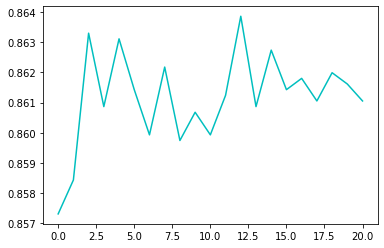

In [15]:
hnd2, = plt.plot(acc_al2,'c',label='ActiveLearning')

In [16]:
output = pd.read_csv("output.csv")
output['acc_al2'] = acc_al2
output.to_csv("output.csv")

In [17]:
output

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,acc_co2al2,acc_al2,acc_coal2
0,0,0,0,0.857866,0.857304,0.860866
1,1,1,1,0.859179,0.858429,0.860866
2,2,2,2,0.861804,0.863304,0.863304
3,3,3,3,0.861241,0.860866,0.863866
4,4,4,4,0.861429,0.863116,0.862179
5,5,5,5,0.863116,0.861429,0.860304
6,6,6,6,0.861804,0.859929,0.861616
7,7,7,7,0.862366,0.862179,0.863116
8,8,8,8,0.861804,0.859741,0.862554
9,9,9,9,0.860866,0.860679,0.863866


In [19]:
output.to_excel('output.xlsx')